In [7]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler

GAMMA = 0.9
ALPHA = 0.1

In [8]:
def epsilon_greedy(model, s, eps=0.1):
    p = np.random.random()
    if p < (1 - eps):
        values = model.predict_all_actions(s)
        return np.argmax(values)
    else:
        return model.env.action_space.sample()

def gather_samples(env, n_episodes=10000):
    samples = []
    for _ in range(n_episodes):
        s, info = env.reset()
        done = False
        truncated = False
        while not (done or truncated):
            a = env.action_space.sample()
            sa = np.concatenate((s, [a]))
            samples.append(sa)

            s, r, done, truncated, info = env.step(a)
    return samples

In [9]:
class Model:
    def __init__(self, env):
        self.env = env
        samples = gather_samples(env)
        self.featurizer = RBFSampler()
        self.featurizer.fit(samples)
        dims = self.featurizer.n_components

        self.w = np.zeros(dims)

    def predict(self, s, a):
        sa = np.concatenate((s, [a]))
        x = self.featurizer.transform([sa])[0]
        return x @ self.w

    def predict_all_actions(self, s):
        return [self.predict(s, a) for a in range(self.env.action_space.n)]

    def grad(self, s, a):
        sa = np.concatenate((s, [a]))
        x = self.featurizer.transform([sa])[0]
        return x

In [10]:
def test_agent(model, env, n_episodes=20):
    reward_per_episode = np.zeros(n_episodes)
    for it in range(n_episodes):
        done = False
        truncated = False
        episode_reward = 0
        s, info = env.reset()
        while not (done or truncated):
            a = epsilon_greedy(model, s, eps=0)
            s, r, done, truncated, info = env.step(a)
            episode_reward += r
        reward_per_episode[it] = episode_reward
    return np.mean(reward_per_episode)

def watch_agent(model, env, eps):
    done = False
    truncated = False
    episode_reward = 0

    s, info = env.reset()
    while not (done or truncated):
        a = epsilon_greedy(model, s, eps=eps)
        s, r, done, truncated, info = env.step(a)
        episode_reward += r
    print("Episode reward:", episode_reward)

Episode reward: 9.0
Epissode: 50, Reward: 15.0
Epissode: 100, Reward: 42.0
Epissode: 150, Reward: 153.0
Epissode: 200, Reward: 500.0
Epissode: 250, Reward: 500.0
Epissode: 300, Reward: 381.0
Epissode: 350, Reward: 224.0
Epissode: 400, Reward: 175.0
Epissode: 450, Reward: 181.0
Epissode: 500, Reward: 147.0
Epissode: 550, Reward: 129.0
Epissode: 600, Reward: 110.0
Epissode: 650, Reward: 159.0
Epissode: 700, Reward: 172.0
Epissode: 750, Reward: 206.0
Epissode: 800, Reward: 500.0
Epissode: 850, Reward: 277.0
Epissode: 900, Reward: 223.0
Epissode: 950, Reward: 217.0
Epissode: 1000, Reward: 297.0
Epissode: 1050, Reward: 296.0
Epissode: 1100, Reward: 328.0
Epissode: 1150, Reward: 239.0
Epissode: 1200, Reward: 325.0
Epissode: 1250, Reward: 399.0
Epissode: 1300, Reward: 229.0
Epissode: 1350, Reward: 231.0
Epissode: 1400, Reward: 198.0
Epissode: 1450, Reward: 241.0
Epissode: 1500, Reward: 209.0
Average test reward: 171.2


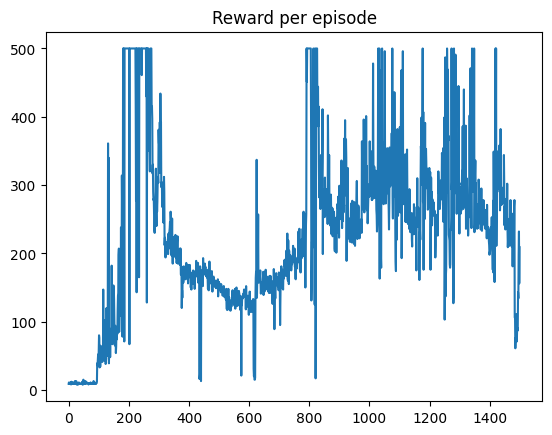

In [12]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

model = Model(env)
reward_per_episode = []

watch_agent(model, env, eps=0)

n_episodes = 1500
for it in range(n_episodes):
    s, info  = env.reset()
    episode_reward = 0
    done = False
    truncated = False
    while not (done or truncated):
        a = epsilon_greedy(model, s)
        s2, r, done, truncated, info = env.step(a)

        if done:
            target = r
        else:
            values = model.predict_all_actions(s2)
            target = r + GAMMA * np.max(values)

        # update the model
        g = model.grad(s, a)
        err = target - model.predict(s, a)
        model.w += ALPHA * err * g

        episode_reward += r
        s = s2

    if (it + 1) % 50 == 0:
        print(f"Epissode: {it + 1}, Reward: {episode_reward}")

    if it > 20 and np.mean(reward_per_episode[-20:]) == 200:
        print("Early exit")
        break

    reward_per_episode.append(episode_reward)

test_reward = test_agent(model, env)
print(f"Average test reward: {test_reward}")

plt.plot(reward_per_episode)
plt.title("Reward per episode")
plt.show()

In [13]:
env = gym.make("CartPole-v1", render_mode="human")
watch_agent(model, env, eps=0)

Episode reward: 161.0


: 